# Writing while reading from the files

fio was used to write a single file. A reader program reads the file that fio opened. If zero bytes are read because
the end of the file was reached the reader will sleep for 100 ms. 

Three test were performed:

* a single reader
* no reader
* eight reader, each one running on a different node

The writer is always on a different node then the readers are. The readers read the whole files. This is an unrealistic situtation
as for LCLS each of the N reader will read only 1/N-th of a file (to first approximation). 

In [1]:
import sys
import jmespath

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

import fiostats

plt.style.use('ggplot')

In [2]:
all_data = []
cfg = []
for date, name in zip(('20190430T102000', '20190430T102702', '20190430T103647'), ('single-reader', 'no-reader', 'many-reader')):
    all_data.append(fiostats.read_test_sequence("rww/{}".format(date)))
    cfg.append({'date': date, 'name': name})

Found for rww/20190430T102000 1 tests
Found for rww/20190430T102702 1 tests
Found for rww/20190430T103647 1 tests


# Average write rates

In [3]:
print(jmespath.search('[*][*].timestamp', all_data))
bw = np.array(jmespath.search('[*][*].jobs[*].write.bw_mean', all_data))
bw.shape = 3
bw /= 1024.
for cf, rate in zip(cfg, bw):
    print("{:14s} {:.1f}".format(cf['name'],rate))

[[1556645066], [1556645433], [1556646059]]
single-reader  781.4
no-reader      970.2
many-reader    905.9


# Latency for the writer

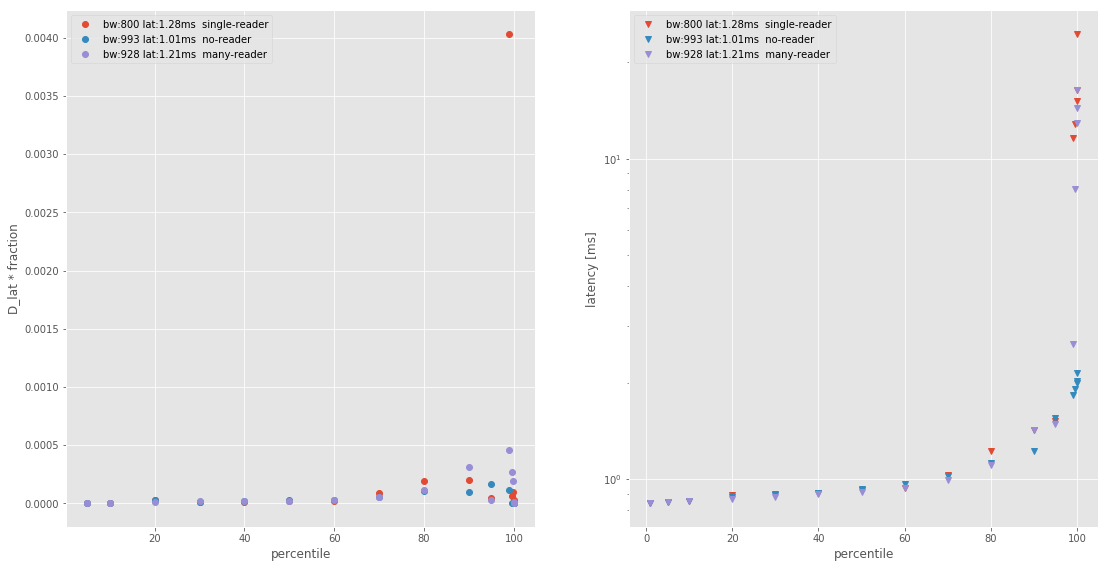

In [4]:
f, (ax1, ax2) = plt.subplots(1, 2)
f.set_size_inches(18.5, 9.5)

for cf, tst in zip(cfg, all_data):
    bw = jmespath.search('[*].jobs[*].write.bw_mean', tst)[0][0] / 1000.
    mlat = jmespath.search('[*].jobs[*].write.clat_ns.mean', tst)[0][0] / 1.0E6
    q = jmespath.search('[*].jobs[*].write.clat_ns.percentile', tst)[0][0]
    x = np.fromiter((e[0] for e in q.items() if float(e[0]) > 0.0), dtype=np.float)
    y = np.fromiter((e[1] for e in q.items() if float(e[0]) > 0.0), dtype=np.float) / 1.0E6   # latency in ms
    dy = y[1:] - y[0:-1]
    dx = (x[1:] - x[:-1]) / 100.0
    ltext = "bw:{:.0f} lat:{:.2f}ms  {}".format(bw, mlat, cf['name'])
    ax1.plot(x[1:],dy*dx/100, 'o', label=ltext)
    ax2.plot(x,y, 'v', label=ltext)

ax1.set_xlabel("percentile")
ax1.set_ylabel("D_lat * fraction")
ax1.legend()
ax2.set_xlabel("percentile")
ax2.set_ylabel("latency [ms]")
ax2.set_yscale('log')
ax2.legend()
plt.savefig("pics/rww_latency.png")
